### _in silico_ perturbation by cell type prompting

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

In [2]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [3]:
# arguments
query_gene_ids = ctx.model_var_names
assay = "10x 3' v2"
suspension_type = "cell"
prompt_metadata_dict = {
    "cell_type": "CD8-positive, alpha-beta T cell",
    "tissue": "blood"
}
total_mrna_umis = 10_000

### Gene expression dynamic range determination

In [4]:
query_chunk_size = 1_000
upper_percentile = 0.5
max_counts = 2000
upper_pad = 1

gex_range_dict = ctx.predict_gene_expression_range_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=query_gene_ids,
    query_chunk_size=query_chunk_size,
    total_prob_mass=upper_percentile,
    symmetric_range_pad=upper_pad,
    max_counts=max_counts,
)

Processing gene chunks:   0%|          | 0/37 [00:00<?, ?it/s]

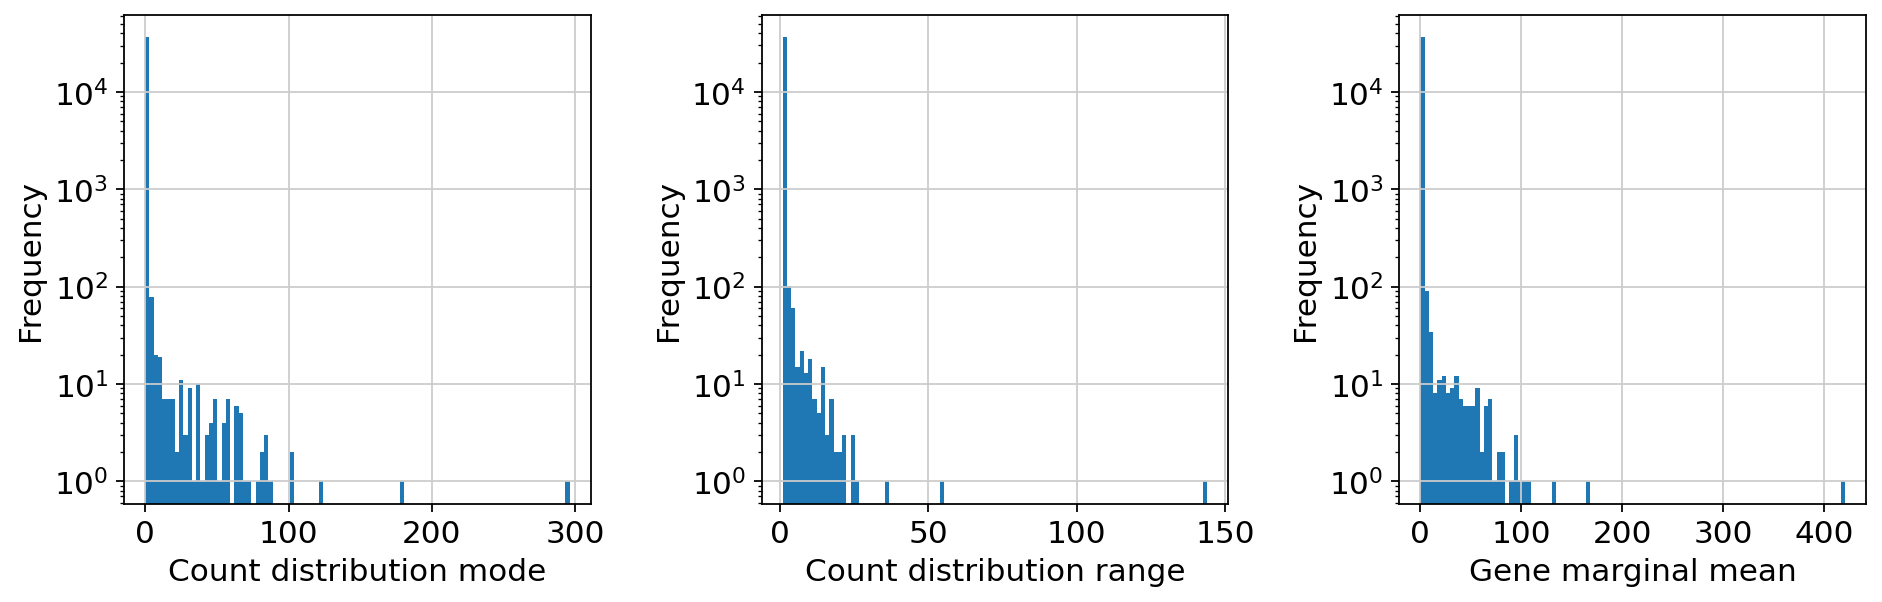

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax = axs[0]
ax.hist(gex_range_dict['gene_logits_mode_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Count distribution mode");
ax.set_ylabel("Frequency");

ax = axs[1]
ax.hist(gex_range_dict['range_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Count distribution range");
ax.set_ylabel("Frequency");

ax = axs[2]
ax.hist(gex_range_dict['gene_marginal_mean_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Gene marginal mean");
ax.set_ylabel("Frequency");

fig.tight_layout()

In [6]:
# print gene symbols for top 10 genes in terms of mode
top_k = 50
top_k_genes = sorted(
    zip(query_gene_ids,
        gex_range_dict['gene_logits_mode_q'].cpu().numpy(),
        gex_range_dict['gene_marginal_mean_q'].cpu().numpy()), key=lambda x: x[2], reverse=True)[:top_k]
for gene_id, mode, mean in top_k_genes:
    print(f'{ctx.gene_id_to_gene_symbol_map[gene_id]}, mode: {mode}, mean: {mean:.2f}')

MALAT1, mode: 296, mean: 420.55
TMSB4X, mode: 179, mean: 164.94
B2M, mode: 122, mean: 133.06
EEF1A1, mode: 102, mean: 105.39
RPS27, mode: 102, mean: 104.24
RPS18, mode: 86, mean: 99.17
RPL41, mode: 83, mean: 95.43
RPL10, mode: 83, mean: 94.16
RPLP1, mode: 81, mean: 92.55
RPL13A, mode: 83, mean: 90.35
RPL13, mode: 78, mean: 83.35
RPS12, mode: 81, mean: 80.84
RPS2, mode: 73, mean: 79.76
RPS19, mode: 68, mean: 75.85
RPL21, mode: 71, mean: 72.20
RPL34, mode: 68, mean: 70.94
RPL28, mode: 66, mean: 70.34
ACTB, mode: 57, mean: 69.83
MT-CO1, mode: 57, mean: 69.81
RPS14, mode: 63, mean: 69.36
RPS29, mode: 68, mean: 69.11
RPLP2, mode: 66, mean: 68.51
RPS6, mode: 63, mean: 66.86
RPL32, mode: 63, mean: 66.72
RPS3, mode: 63, mean: 64.11
RPS15A, mode: 63, mean: 64.06
RPS27A, mode: 63, mean: 64.02
TMSB10, mode: 57, mean: 63.30
RPL3, mode: 57, mean: 61.58
RPS4X, mode: 57, mean: 59.67
RPL18A, mode: 57, mean: 58.87
RPL26, mode: 54, mean: 58.81
RPL39, mode: 56, mean: 58.43
RPL27A, mode: 56, mean: 57.82
R

mode: 296, range: 144
lo: 152, hi: 440


Text(0, 0.5, 'Probability')

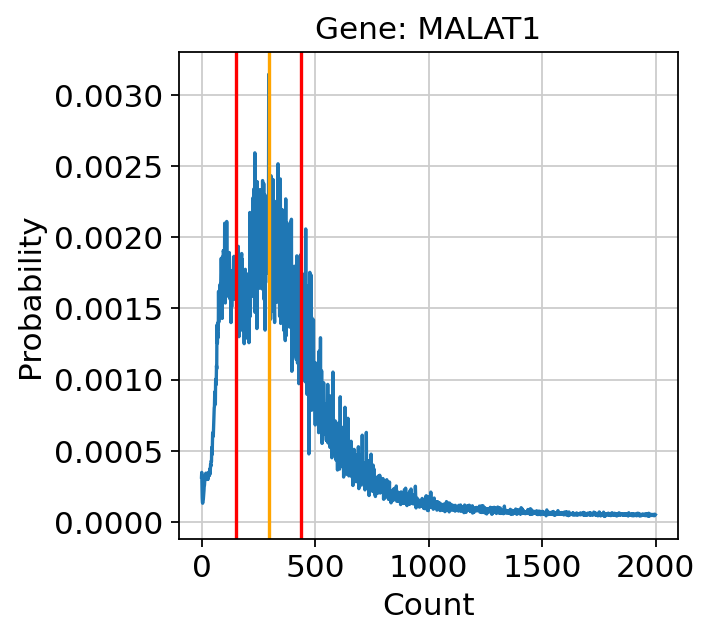

In [7]:
gene_symbol = 'MALAT1'
q = ctx.var_name_to_index_map[ctx.gene_symbol_to_gene_id_map[gene_symbol]]

print(f"mode: {gex_range_dict['gene_logits_mode_q'][q].item()}, range: {gex_range_dict['range_q'][q].item()}")
print(f"lo: {gex_range_dict['x_lo_q'][q].item()}, hi: {gex_range_dict['x_hi_q'][q].item()}")

query_id = query_gene_ids[q]
gene_symbol = ctx.gene_id_to_gene_symbol_map[query_id]

fig, ax = plt.subplots()

ax.plot(
    np.arange(max_counts),
    gex_range_dict['gene_logits_qk'][q].exp().cpu().numpy(), '-')
ax.axvline(gex_range_dict['x_lo_q'][q].item(), color='red')
ax.axvline(gex_range_dict['x_hi_q'][q].item(), color='red')
ax.axvline(gex_range_dict['gene_logits_mode_q'][q].item(), color='orange')

ax.set_title(f"Gene: {gene_symbol}")
ax.set_xlabel("Count")
ax.set_ylabel("Probability")

In [8]:
gene_logits_qk = gex_range_dict['gene_logits_qk']
gene_logits_mode_q = gex_range_dict['gene_logits_mode_q']
gene_marginal_mean_q = gex_range_dict['gene_marginal_mean_q']
gene_marginal_std_q = gex_range_dict['gene_marginal_std_q']
gene_logits_mode_q = gex_range_dict['gene_logits_mode_q']
range_q =  gex_range_dict['range_q']
x_lo_q = gex_range_dict['x_lo_q']
x_hi_q = gex_range_dict['x_hi_q']

# let's pick genes to perturb (and query) that make sense for this cell type
expr_threshold_tpm = 10.
expr_threshold_mean = expr_threshold_tpm * total_mrna_umis / 1e6
expressed_mask_q = (gene_marginal_mean_q >= expr_threshold_mean).cpu().numpy()

filtered_query_gene_ids = query_gene_ids[expressed_mask_q]
filtered_perturb_gene_ids = query_gene_ids[expressed_mask_q]
filtered_query_gene_symbols = [ctx.gene_id_to_gene_symbol_map[gid] for gid in filtered_query_gene_ids]
filtered_perturb_gene_symbols = [ctx.gene_id_to_gene_symbol_map[gid] for gid in filtered_perturb_gene_ids]
filtered_x_lo_q = x_lo_q.cpu().numpy()[expressed_mask_q]
filtered_x_hi_q = x_hi_q.cpu().numpy()[expressed_mask_q]

print("Number of genes to perturb:", len(filtered_perturb_gene_ids))
print("Number of genes to query:", len(filtered_query_gene_ids))

Number of genes to perturb: 6321
Number of genes to query: 6321


In [79]:
n_points = 5
query_chunk_size = 64

dose_response_dict = ctx.generate_gene_dose_response_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=filtered_query_gene_ids,
    perturb_gene_ids=filtered_perturb_gene_ids,
    x_lo_p=filtered_x_lo_q,
    x_hi_p=filtered_x_hi_q,
    n_points=n_points,
    query_chunk_size=query_chunk_size,
    max_counts=max_counts,
)

Processing dose quantiles:   0%|          | 0/5 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
# import pickle

# with open('/home/mehrtash/data/cd8_dose_response_dict_tpm_0.1.pkl', 'wb') as f:
#     pickle.dump(dose_response_dict, f)

In [10]:
import pickle

with open('/home/mehrtash/data/cd8_dose_response_dict.pkl', 'rb') as f:
    dose_response_dict = pickle.load(f)

In [11]:
dose_response_dict.keys()

dict_keys(['doses_pi', 'responses_mean_pqi', 'responses_std_pqi', 'control_mean_q', 'control_std_q'])

In [12]:
for i, gene_id in enumerate(filtered_query_gene_ids):
    print(i, filtered_query_gene_symbols[i])

0 SDF4
1 FAAP20
2 ARMH1
3 SERBP1
4 PRKACB
5 GTF2B
6 MTF2
7 HENMT1
8 PRPF38B
9 DAP3
10 ARHGEF2
11 UHMK1
12 RABIF
13 PYCR2
14 ACBD3
15 MTR
16 LPIN1
17 DDX1
18 MRPL35
19 RAB3GAP1
20 ORMDL1
21 ANKZF1
22 SP100
23 TADA3
24 ACAA1
25 CTNNB1
26 TMEM42
27 TOMM70
28 LRRC58
29 MAEA
30 LYAR
31 FGFBP2
32 NUP54
33 BRD9
34 PELO
35 GZMK
36 CAMK4
37 NR3C1
38 CANX
39 TRIM52
40 BTN3A3
41 DDX39B
42 ILRUN
43 FBXO9
44 CRYBG1
45 GTF3C6
46 IFNGR1
47 SNX9
48 C7orf50
49 KDELR2
50 CCT6A
51 CBLL1
52 ING3
53 PPP2R2A
54 RPL30
55 RNF19A
56 ZNF706
57 EFR3A
58 FGD3
59 NDUFA8
60 MLLT10
61 ITPRIP
62 PTPRE
63 IFITM2
64 ZNRD2
65 MRE11
66 CUL5
67 PTMS
68 PTPN6
69 LETMD1
70 ARHGAP9
71 CAND1
72 NUP37
73 GPN3
74 SPRING1
75 APEX1
76 SPTSSA
77 ATP6V1D
78 IFT43
79 FOXN3
80 MARK3
81 SPG11
82 FEM1B
83 TLE3
84 GNPTG
85 FLYWCH2
86 NPIPB5
87 PSMB10
88 NIP7
89 KARS1
90 MAF
91 PLCG2
92 XAF1
93 NCOR1
94 SLFN5
95 SNHG30
96 CCR7
97 TMUB2
98 SEC14L1
99 OGFOD3
100 RNF125
101 PIAS2
102 TMX3
103 DNMT1
104 SAMD4B
105 TOMM40
106 NUCB1
107 MKKS
1

Text(0, 0.5, 'Response of GZMA')

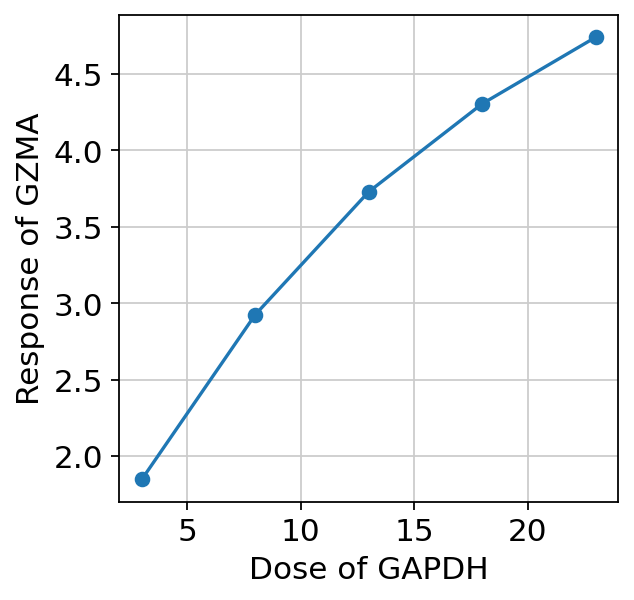

In [13]:
p = filtered_perturb_gene_symbols.index('GAPDH')
q = filtered_query_gene_symbols.index('GZMA')

fig, ax = plt.subplots()

ax.plot(dose_response_dict['doses_pi'][p, :], dose_response_dict['responses_mean_pqi'][p, q, :], marker='o')
ax.set_xlabel(f"Dose of {filtered_perturb_gene_symbols[p]}")
ax.set_ylabel(f"Response of {filtered_query_gene_symbols[q]}")

In [14]:
import numpy as np
from scipy.stats import linregress

def batch_linear_regression(x_bn, y_bn):
    """
    Perform batch-mode one-dimensional linear regression on data with arbitrary batch dimensions.
    
    For each batch (with indices b), we assume a linear model:
    
        y_bn = slope_b * x_bn + intercept_b + error_bn
    
    where:
      - x_bn and y_bn are arrays of shape (..., n), with the rightmost dimension (n) 
        representing the samples,
      - the leftmost dimensions (possibly several) are treated as batch dimensions.
    
    Parameters
    ----------
    x_bn : np.ndarray
        Array of covariates with shape (..., n).
    y_bn : np.ndarray
        Array of responses with shape (..., n).
        
    Returns
    -------
    slope_b : np.ndarray
        Array of slopes with shape equal to the batch shape.
        For any batch where the variance of x_bn is zero, the slope is set to 0.
    intercept_b : np.ndarray
        Array of intercepts with shape equal to the batch shape.
    r_squared_b : np.ndarray
        Array of R-squared values with shape equal to the batch shape.
        For any batch where the total variance of y_bn is zero, r_squared_b is defined as 1.
    """
    # Assert that inputs are numpy arrays of the same shape.
    assert isinstance(x_bn, np.ndarray), "x_bn must be a numpy array"
    assert isinstance(y_bn, np.ndarray), "y_bn must be a numpy array"
    assert x_bn.shape == y_bn.shape, "x_bn and y_bn must have the same shape"
    assert x_bn.ndim >= 1, "x_bn and y_bn must have at least one dimension (samples)"

    # Compute the means along the sample dimension (rightmost axis) and keep that dimension.
    # The resulting arrays have shape (..., 1) and are named with a '_b1' suffix.
    x_mean_b1 = np.mean(x_bn, axis=-1, keepdims=True)  # shape: (..., 1)
    y_mean_b1 = np.mean(y_bn, axis=-1, keepdims=True)  # shape: (..., 1)
    
    # Compute the covariance for each batch:
    #   cov_b = sum_n[(x_bn - x_mean_b1) * (y_bn - y_mean_b1)]
    cov_b = np.sum((x_bn - x_mean_b1) * (y_bn - y_mean_b1), axis=-1)  # shape: batch shape
    
    # Compute the variance of x for each batch:
    #   var_x_b = sum_n[(x_bn - x_mean_b1)^2]
    var_x_b = np.sum((x_bn - x_mean_b1)**2, axis=-1)  # shape: batch shape
    
    # Compute the slope for each batch, using np.divide to avoid division by zero.
    slope_b = np.divide(cov_b, var_x_b, out=np.zeros_like(cov_b), where=(var_x_b != 0))
    
    # Compute the intercept for each batch.
    intercept_b = y_mean_b1.squeeze(-1) - slope_b * x_mean_b1.squeeze(-1)
    
    # Compute the predicted responses for each batch:
    #   yhat_bn = slope_b * x_bn + intercept_b (broadcasting over the sample dimension)
    yhat_bn = slope_b[..., None] * x_bn + intercept_b[..., None]
    
    # Compute the residual sum of squares (SS_res) and total sum of squares (SS_tot) for each batch.
    ss_res_b = np.sum((y_bn - yhat_bn)**2, axis=-1)
    ss_tot_b = np.sum((y_bn - y_mean_b1)**2, axis=-1)
    
    # Compute R-squared for each batch. If ss_tot_b == 0, define R-squared as 1.
    r_squared_b = np.where(ss_tot_b != 0, 1 - ss_res_b / ss_tot_b, 1.0)
    
    return slope_b, intercept_b, r_squared_b

def test_batch_linear_regression():
    """
    Test the batch_linear_regression function by comparing its outputs with:
      1. Running each batch individually using scipy.stats.linregress.
      2. Ensuring that processing the batches together or one at a time yield the same results.
    """
    # Set a random seed for reproducibility.
    np.random.seed(0)
    
    # Define a batch shape (can be multidimensional) and number of samples.
    batch_shape = (3, 4)  # Two batch dimensions for demonstration.
    num_samples = 100     # Rightmost dimension: sample index.
    
    # Generate random covariate data with shape (3, 4, 100).
    x_bn = np.random.rand(*batch_shape, num_samples)
    
    # Define true slopes and intercepts for each batch.
    true_slopes = np.linspace(0.5, 2.0, num=np.prod(batch_shape)).reshape(*batch_shape, 1)
    true_intercepts = np.linspace(1.0, 3.0, num=np.prod(batch_shape)).reshape(*batch_shape, 1)
    
    # Generate responses with added noise.
    noise_bn = np.random.randn(*batch_shape, num_samples) * 0.1
    y_bn = true_intercepts + true_slopes * x_bn + noise_bn
    
    # Use our batch regression implementation.
    slope_b, intercept_b, r_squared_b = batch_linear_regression(x_bn, y_bn)
    
    # Now, compute the regression parameters one batch at a time using scipy.stats.linregress.
    # We'll flatten the batch dimensions for easier iteration.
    x_bn_flat = x_bn.reshape(-1, num_samples)
    y_bn_flat = y_bn.reshape(-1, num_samples)
    
    slopes_scipy = np.empty(x_bn_flat.shape[0])
    intercepts_scipy = np.empty(x_bn_flat.shape[0])
    r_squared_scipy = np.empty(x_bn_flat.shape[0])
    
    for i in range(x_bn_flat.shape[0]):
        x_n = x_bn_flat[i]
        y_n = y_bn_flat[i]
        result = linregress(x_n, y_n)
        slopes_scipy[i] = result.slope
        intercepts_scipy[i] = result.intercept
        r_squared_scipy[i] = result.rvalue**2  # R-squared is the square of the r-value.
    
    # Reshape the individual results to the original batch shape.
    slopes_scipy = slopes_scipy.reshape(batch_shape)
    intercepts_scipy = intercepts_scipy.reshape(batch_shape)
    r_squared_scipy = r_squared_scipy.reshape(batch_shape)
    
    # Assert that the batch regression results match the individual regressions.
    assert np.allclose(slope_b, slopes_scipy, atol=1e-6), "Slopes do not match between batch and individual regressions."
    assert np.allclose(intercept_b, intercepts_scipy, atol=1e-6), "Intercepts do not match between batch and individual regressions."
    assert np.allclose(r_squared_b, r_squared_scipy, atol=1e-6), "R-squared values do not match between batch and individual regressions."
    
    print("Test passed: Batch regression results match individual regressions and scipy.linregress results.")

In [15]:
n_query_vars = len(filtered_query_gene_ids)
n_perturb_vars = len(filtered_perturb_gene_ids)

doses_pi = dose_response_dict['doses_pi']
responses_mean_pqi = dose_response_dict['responses_mean_pqi']

slope_qp, intercept_qp, r_squared_qp = batch_linear_regression(
    x_bn=np.repeat(doses_pi[None, :, :], n_query_vars, axis=-3),
    y_bn=responses_mean_pqi.transpose(1, 0, 2)
)

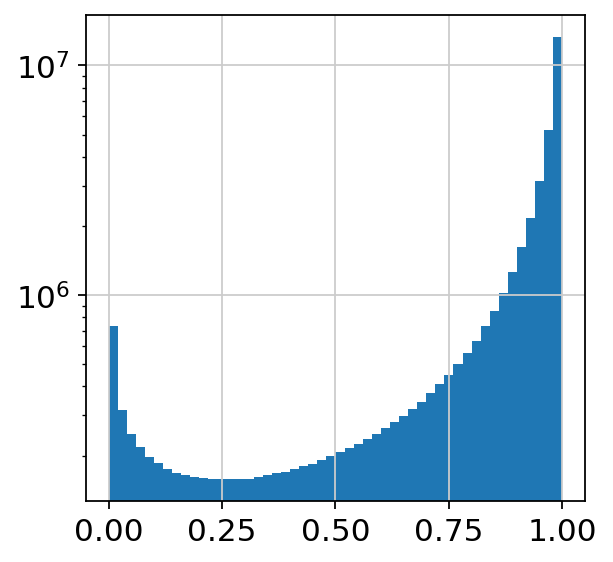

In [16]:
plt.hist(r_squared_qp.flatten(), bins=50, log=True);

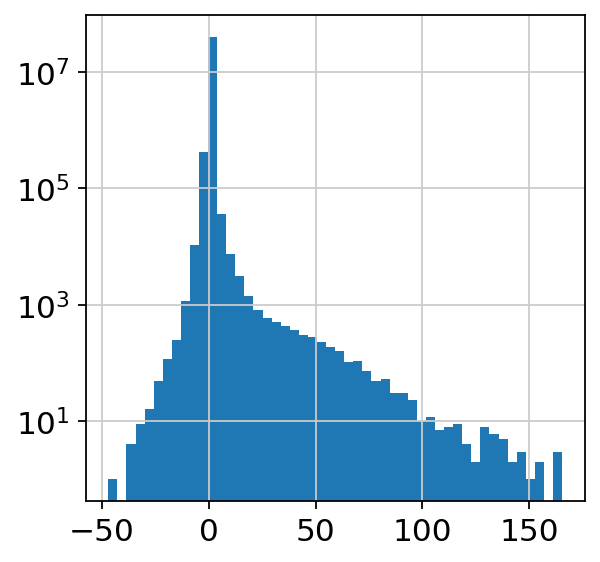

In [17]:
plt.hist(slope_qp.flatten(), bins=50, log=True);

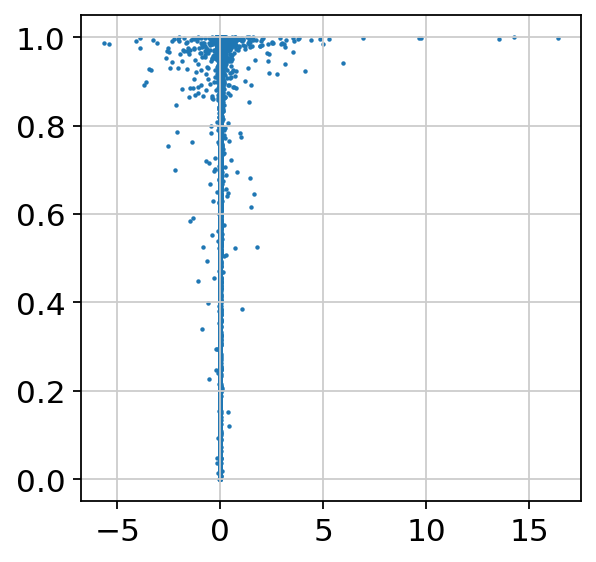

In [18]:
n_points = 10_000
size = slope_qp.shape[0] * slope_qp.shape[1]
rand_indices = np.random.permutation(size)[:n_points]
x = slope_qp.flatten()[rand_indices]
y = r_squared_qp.flatten()[rand_indices]
plt.scatter(x, y, s=1);

In [19]:
# Generate an AnnData containing just the metadata
adata_prop = sc.AnnData(
    X=np.zeros((1, 1)),
    obs=pd.DataFrame({
        "cell_type": [prompt_metadata_dict["cell_type"]],
        "tissue": [prompt_metadata_dict["tissue"]],
        "assay": [assay],
        "suspension_type": [suspension_type],
        "total_mrna_umis": [total_mrna_umis],
        "disease": "N/A",
        "development_stage": "N/A",
        "sex": "N/A",
    })
)

gene_info_tsv_path = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

response_qp = slope_qp.copy()
response_qp[r_squared_qp < 0.25] = 0.
prompt_marginal_mean_p = dose_response_dict["control_mean_q"]
prompt_marginal_std_p = dose_response_dict["control_std_q"]
query_marginal_mean_q = dose_response_dict["control_mean_q"]
query_marginal_std_q = dose_response_dict["control_std_q"]

network_ctx = GeneNetworkAnalysisBase(
    adata_obs=adata_prop.obs,
    gene_info_tsv_path=gene_info_tsv_path,
    query_var_names=filtered_query_gene_ids.tolist(),
    prompt_var_names=filtered_perturb_gene_ids.tolist(),
    response_qp=response_qp,
    prompt_marginal_mean_p=prompt_marginal_mean_p,
    prompt_marginal_std_p=prompt_marginal_std_p,
    query_marginal_mean_q=query_marginal_mean_q,
    query_marginal_std_q=query_marginal_std_q,
    verbose=True
)

In [ ]:
network_ctx.process(
    response_normalization_strategy="mean",
    feature_normalization_strategy="none",
    feature_max_value=None,
    query_response_amp_min_pct=None,
    min_prompt_gene_tpm=0,
    min_query_gene_tpm=0,
    norm_pseudo_count=1e-3,
    query_hv_top_k=4000
    # z_trans_func=lambda x: 10. * np.tanh(0.1 * x)
)

2025-02-13 18:28:47,825 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Maximum value of z_qp: 87.419
2025-02-13 18:28:48,076 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Minimum value of z_qp: -192.053
2025-02-13 18:28:48,077 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Number of query genes after TPM filtering: 19187 / 19187
2025-02-13 18:28:48,078 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Number of prompt genes after TPM filtering: 19187 / 19187


In [21]:
z_qp = network_ctx.z_qp

In [33]:
a = np.random.randn(5, 10)

In [37]:
std_p = np.std(z_qp, axis=0)
std_q = np.std(z_qp, axis=1)

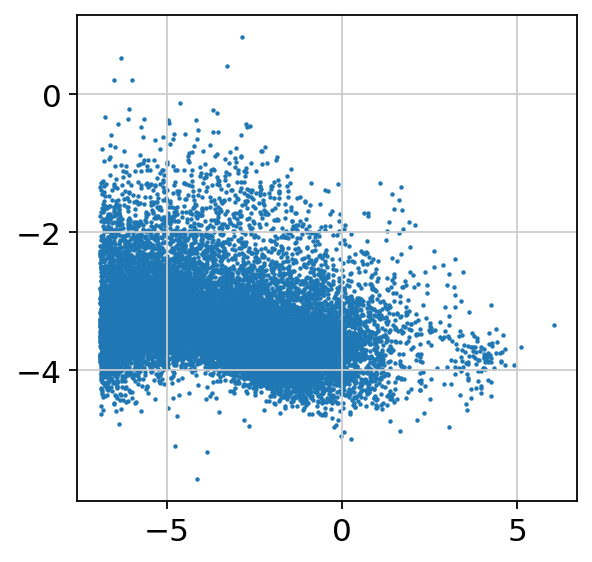

In [38]:
plt.scatter(np.log(query_marginal_mean_q), np.log(std_q), s=1);

In [73]:
inds, y = quantile_normalize_select(
    x=np.log(1 + query_marginal_mean_q),
    y=np.log(std_q),
    n_bins=50,
    top_k=4000,
    min_x=1e-2,
    max_x=np.inf)

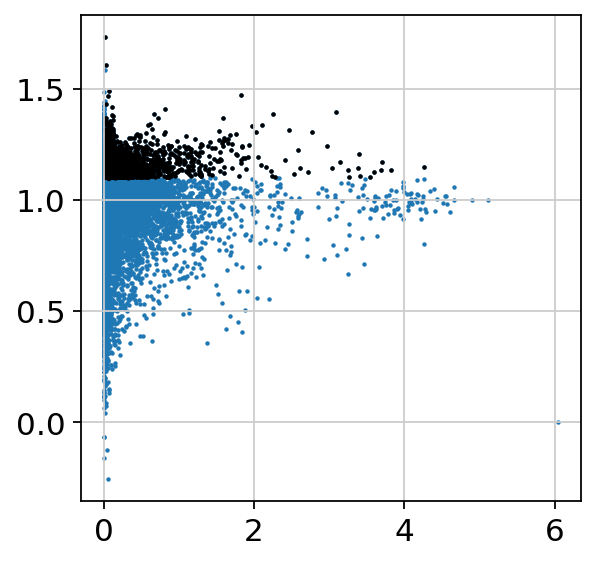

In [74]:
plt.scatter(x, y, s=1)
plt.scatter(x[inds], y[inds], s=1, color='black')

In [147]:
network_ctx.compute_adjacency_matrix(
    adjacency_strategy="positive_correlation",
    n_neighbors=50,
    beta=6.,
    self_loop=False)

In [148]:
i = network_ctx.prompt_gene_id_to_idx_map[network_ctx.gene_symbol_to_gene_id_map['MALAT1']]
inds = np.argsort(network_ctx.a_pp[i, :])[::-1]
for j in inds[:100]:
    print(filtered_perturb_gene_symbols[j], network_ctx.a_pp[i, j])

RPS29 0.25002084343528413
RPS27 0.21294385750728573
RPL27A 0.1590639182449272
RPL41 0.14990689821601214
RPLP2 0.13662548202267263
RPL13A 0.13641175988069157
RPL21 0.11553732740678681
RPS17 0.08892434738396542
RPL37A 0.061956671192742965
RPS20 0.04917304533748178
RPL23A 0.04873089597486011
RPL37 0.046089742866304975
EEF1A1 0.044034336056322405
PCDH11Y 0.04343167968857392
KCNB1 0.04127985377065494
CFAP47 0.03748759320394966
RPL34 0.03587074850772351
RPS2 0.03556800513846539
OTX2-AS1 0.03553745893655207
MT-ND2 0.035414843137776486
PPP1R9A-AS1 0.0338932791690593
LINC00609 0.030390189847234045
B2M 0.029091092346177443
ENSG00000231918 0.028745888666242086
ENSG00000253693 0.027283196696631175
TPT1 0.025285768878777592
KCNH1 0.024198590635440633
MIR4300HG 0.02390461364024318
NLGN4Y 0.02355975181251663
EIF1 0.02352267579187997
NALF1 0.022670562217922328
RFX3 0.022317085872722263
DCC 0.021412266776110075
DSCAM 0.0213945160004499
ENSG00000253190 0.020578815190038117
MIR2052HG 0.02031291760862122


In [149]:
network_ctx.compute_leiden_communites(
    resolution=5.0)

In [150]:
len(np.unique(network_ctx.leiden_membership))

50

#### Embedding

In [151]:
import pymde

network_ctx.make_mde_embedding(
    n_neighbors=20,
    repulsive_penalty=pymde.penalties.Log,
    max_iter=1000,
    init="quadratic",
    device="cuda")

Feb 13 06:20:11 PM: Computing 20-nearest neighbors, with max_distance=None
Thu Feb 13 18:20:12 2025 Building RP forest with 17 trees
Thu Feb 13 18:20:17 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Feb 13 06:20:32 PM: Computing quadratic initialization.
Feb 13 06:20:35 PM: Fitting a centered embedding into R^2, for a graph with 19187 items and 1879506 edges.
Feb 13 06:20:35 PM: `embed` method parameters: eps=1.0e-05, max_iter=1000, memory_size=10
Feb 13 06:20:35 PM: iteration 0000 | distortion 3.861732 | residual norm 0.936287 | step length 0.00684439 | percent change 0.00327134
Feb 13 06:20:36 PM: iteration 0100 | distortion 0.161198 | residual norm 0.000158078 | step length 1 | percent change 0.647835
Feb 13 06:20:37 PM: iteration 0200 | distortion 0.155643 | residual norm 6.65539e-05 | step length 1 | percent change 0.266546
Feb 13 06:20:37 PM: iteration 0300 | distortion 0.152120 | residual norm 

In [152]:
def get_gene_familities(network_ctx: GeneNetworkAnalysisBase, prefix_list: list[str]) -> tuple[list[str], list[str]]:
    _gene_symbols = [gene_symbol for prefix in prefix_list for gene_symbol in network_ctx.query_gene_symbols if gene_symbol.startswith(prefix)]
    gene_ids = [network_ctx.gene_symbol_to_gene_id_map[gene_symbol] for gene_symbol in _gene_symbols]
    gene_symbols = [network_ctx.gene_id_to_gene_symbol_map[gene_id] for gene_id in gene_ids]
    return gene_ids, gene_symbols

mito_gene_ids, mito_gene_symbols = get_gene_familities(network_ctx, ["MT-"])
ribo_gene_ids, ribo_gene_symbols = get_gene_familities(network_ctx, ["RPS", "RPL"])
hla_gene_ids, hla_gene_symbols = get_gene_familities(network_ctx, ["HLA"])
ifi_gene_ids, ifi_gene_symbols = get_gene_familities(network_ctx, ["IFI"])
trav_gene_ids, trav_gene_symbols = get_gene_familities(network_ctx, ["TRAV"])
hb_gene_ids, hb_gene_symbols = get_gene_familities(network_ctx, ["HBA", "HBB"])

highlight_gene_sets = {
    "Mito": (mito_gene_ids, mito_gene_symbols, 'red'),
    "Ribo": (ribo_gene_ids, ribo_gene_symbols, 'blue'),
    "HLA": (hla_gene_ids, hla_gene_symbols, 'green'),
    "IFI": (ifi_gene_ids, ifi_gene_symbols, 'orange'),
    "TRAV": (trav_gene_ids, trav_gene_symbols, 'purple'),
    "HB": (hb_gene_ids, hb_gene_symbols, 'black'),
}

# disable
# highlight_gene_sets = None

In [153]:
network_ctx.plot_mde_embedding(highlight_gene_sets=highlight_gene_sets)